In [22]:
import numpy as np
from enum import Enum

Methods = Enum('Methods', ['Classic', 'Momentum', 'AdaGrad', 'RMSprop', 'Adam', 'Nesterov'])
Regularization = Enum('Regularization', ['WithoutRegularization', 'L1', 'L2', 'Elastic'])
LearningRate = Enum('LearningRate', ['Const', 'Dichotomy'])

def sign(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return -1

class LinearRegression:
    def __init__(self, T, W, X, Y, regularization=Regularization.WithoutRegularization, l1=0.1, l2=0.1):
        self.T = np.array([T[i % len(T)](X[i // len(T)]) for i in range(len(T) * len(X))]).reshape(len(X), len(T))
        self.W = W
        self.X = X
        self.Y = Y
        self.regularization = regularization
        self.l1 = l1
        self.l2 = l2

    def loss_function_value(self, W_Arg):
        val = sum([(np.dot(self.T[i], W_Arg) - self.Y[i]) ** 2 for i in range(len(self.X))])
        match self.regularization:
            case Regularization.L1:
                val += self.l1 * sum([abs(w) for w in self.W]) / len(self.W)
            case Regularization.L2:
                val += self.l2 * sum([w ** 2 for w in self.W]) / len(self.W)
            case Regularization.Elastic:
                val += (self.l1 * sum([abs(w) for w in self.W])) / len(self.W) + (self.l2 * sum([w ** 2 for w in self.W])) / len(self.W)
        return val

    def grad_by_components(self, index_components, W_Arg):
        grad_with_batch = np.zeros(len(W_Arg))
        for i in index_components:
            grad_with_batch += 2 * (np.dot(self.T[i], W_Arg) - self.Y[i]) * self.T[i]
        match self.regularization:
            case Regularization.L1:
                grad_with_batch += self.l1 * np.array([sign(w) for w in self.W]) / len(self.W)
            case Regularization.L2:
                grad_with_batch += self.l2 * 2 * self.W / len(self.W)
            case Regularization.Elastic:
                grad_with_batch += (self.l1 * np.array([sign(w) for w in self.W])) / len(self.W) + (self.l2 * 2 * self.W) / len(self.W)

        return grad_with_batch


def sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, beta_2, eps_adam, is_corr_beta_1=True, is_corr_beta_2=True, is_nesterov=False):
    i = 0
    prev_W = lin_reg.loss_function_value(lin_reg.W)
    V = np.zeros(len(lin_reg.W))
    S = np.zeros(len(lin_reg.W))
    while True:
        components = [(i * batch + j) % len(lin_reg.X) for j in range(batch)]
        grad_with_batch = lin_reg.grad_by_components(components, lin_reg.W)
        alpha = lr(lambda a: lin_reg.loss_function_value(lin_reg.W - a * grad_with_batch))
        V = (beta_1 * V) + (1 - beta_1) * grad_with_batch if ~is_nesterov else (beta_1 * V) + (1 - beta_1) * lin_reg.grad_by_components(lin_reg.W - alpha * beta_1 * V)
        S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2)
        V_norm = V / (1 - (beta_1 ** (i + 1))) if is_corr_beta_1 else V
        S_norm = S / (1 - (beta_2 ** (i + 1))) if is_corr_beta_2 else S
        lin_reg.W -= alpha * (V_norm / (((S_norm) + eps_adam) ** 0.5))
        if abs(lin_reg.loss_function_value(lin_reg.W) - prev_W) < eps or i >= max_num_of_step:
            break
        prev_W = lin_reg.loss_function_value(lin_reg.W)
        i += 1


def sgd_handler(lin_reg, lr, method, batch=1, beta_1=0.9, beta_2=0.999, eps_adam=10 ** -8, eps=0.001, max_num_of_step=10000):
    match method:
        case Methods.Classic:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, 0, 1, 1, False, False)
        case Methods.Momentum:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, 1, 1, False, False)
        case Methods.AdaGrad:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, 0, 0, eps_adam, False, False)
        case Methods.RMSprop:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, 0, beta_2, eps_adam, False)
        case Methods.Adam:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, beta_2, eps_adam)
        case Methods.Nesterov:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, 1, 1, False, False, True)


def lr_dichotomy(eps, delt):
    return lambda lin_reg: dichotomy(lin_reg, 0, right_border_calc(lin_reg), eps, delt)


def right_border_calc(func):
    right_start = 0.0000001
    zero = func(0.)
    while zero >= func(right_start):
        right_start *= 1.3

    return right_start


def dichotomy(func, a_1, a_2, eps, delt):
    while abs(a_1 - a_2) >= eps:
        new_a_1 = (a_1 + a_2) / 2 - delt
        new_a_2 = (a_1 + a_2) / 2 + delt
        fv1 = func(new_a_1)
        fv2 = func(new_a_2)
        if fv2 > fv1:
            a_2 = new_a_2
        elif fv2 < fv1:
            a_1 = new_a_1
        else:
            a_1 = new_a_1
            a_2 = new_a_2
    return (a_1 + a_2) / 2

In [23]:
import matplotlib.pyplot as plt


def visualise_points(linear_reg):
    x = np.linspace(-10, 10, 1000)
    y = linear_reg.W[0] * x + linear_reg.W[1]
    plt.plot(x, y, '-r')
    plt.plot(linear_reg.X, linear_reg.Y, 'og', linestyle='None')
    plt.xlabel("x")
    plt.show()
    print(linear_reg.W)
    print(linear_reg.loss_function_value(linear_reg.W))

Methods.Classic Regularization.WithoutRegularization LearningRate.Const


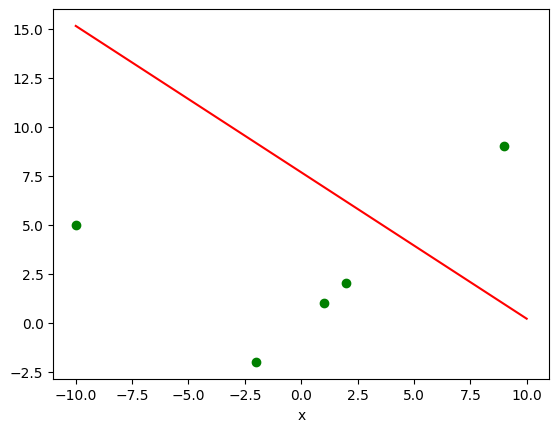

[-0.74654709  7.66981717]
344.65291429435626



Methods.Classic Regularization.WithoutRegularization LearningRate.Dichotomy


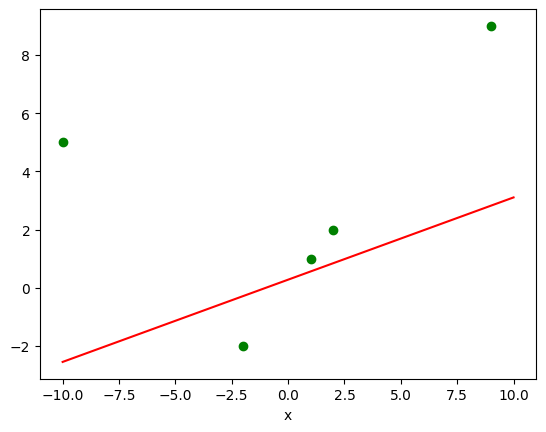

[0.28256078 0.28256067]
99.48723323888015



Methods.Classic Regularization.L1 LearningRate.Const


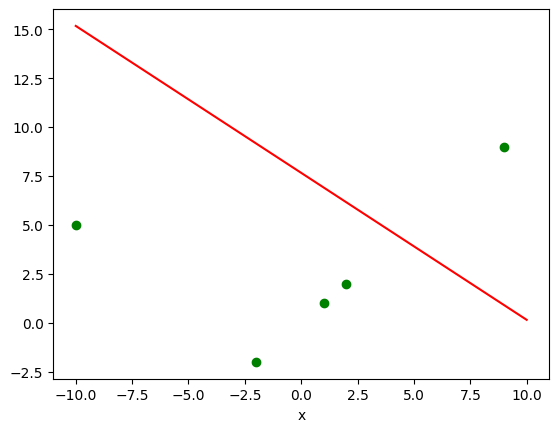

[-0.75099266  7.66097509]
346.28155029949323



Methods.Classic Regularization.L1 LearningRate.Dichotomy


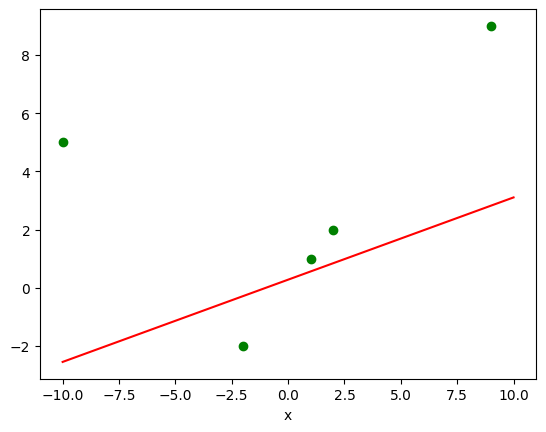

[0.28256078 0.28256067]
99.51548931070113



Methods.Classic Regularization.L2 LearningRate.Const


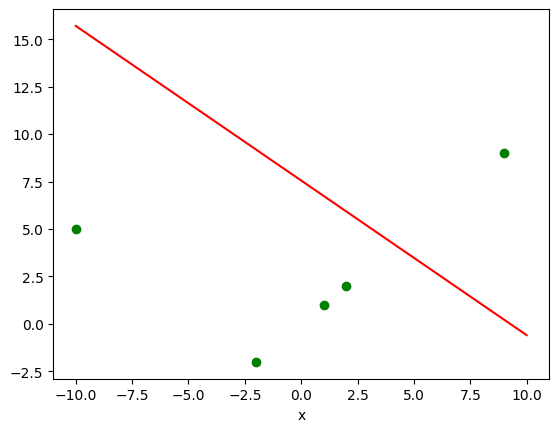

[-0.8144609   7.55315147]
367.73433282488367



Methods.Classic Regularization.L2 LearningRate.Dichotomy


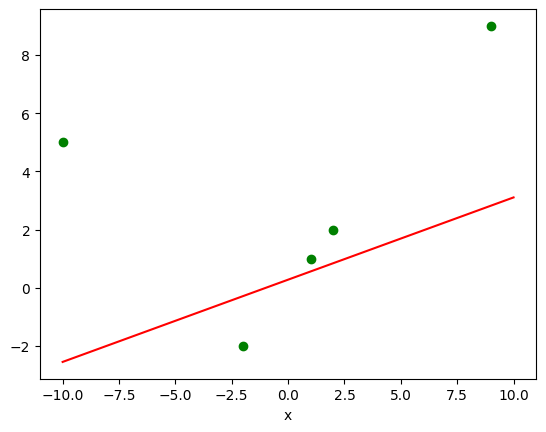

[0.28256078 0.28256067]
99.49521729488909



Methods.Classic Regularization.Elastic LearningRate.Const


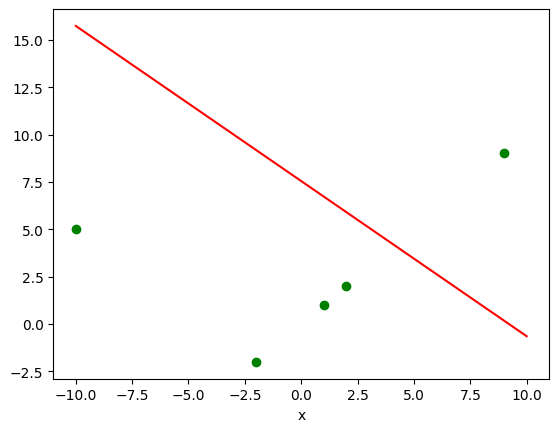

[-0.81882684  7.54442489]
369.45344458114323



Methods.Classic Regularization.Elastic LearningRate.Dichotomy


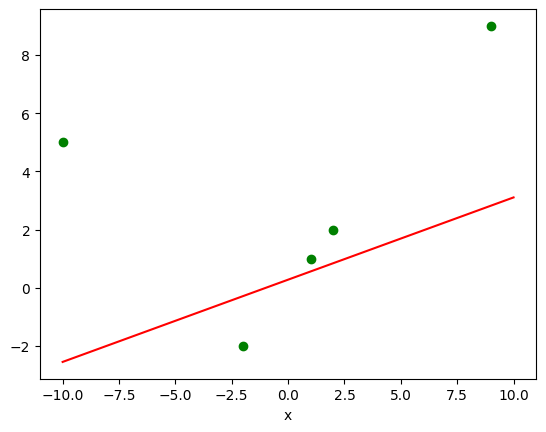

[0.28256078 0.28256066]
99.52347336642751



Methods.Momentum Regularization.WithoutRegularization LearningRate.Const


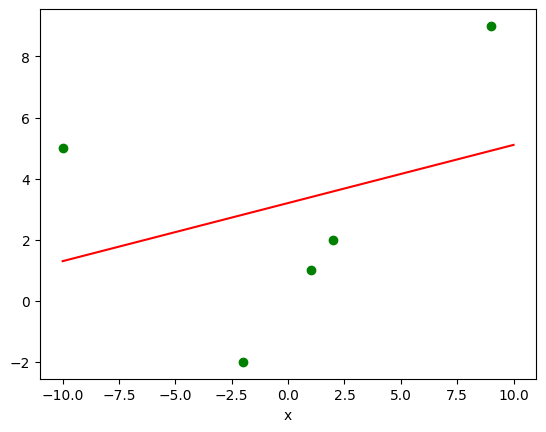

[0.19031467 3.20193538]
61.860453850394336



Methods.Momentum Regularization.WithoutRegularization LearningRate.Dichotomy


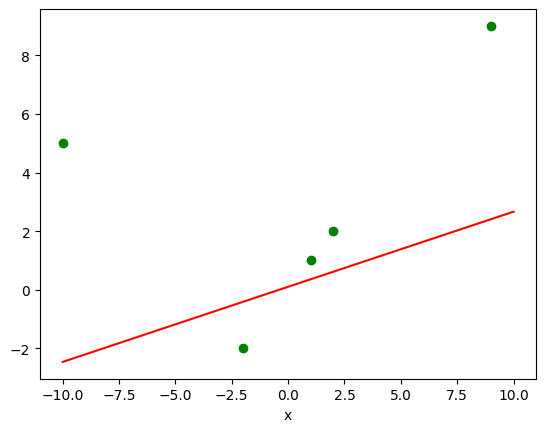

[0.25618592 0.10210597]
103.96400819929238



Methods.Momentum Regularization.L1 LearningRate.Const


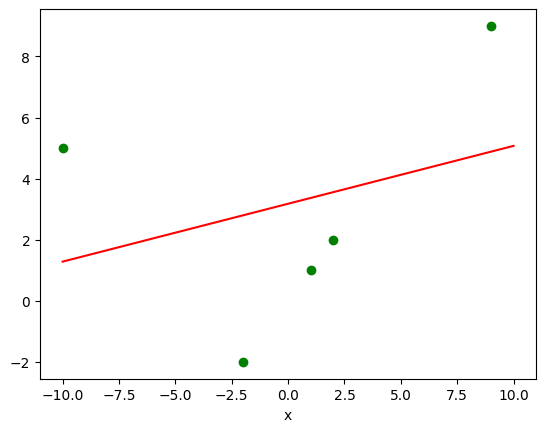

[0.18946588 3.17820835]
61.99039513366119



Methods.Momentum Regularization.L1 LearningRate.Dichotomy


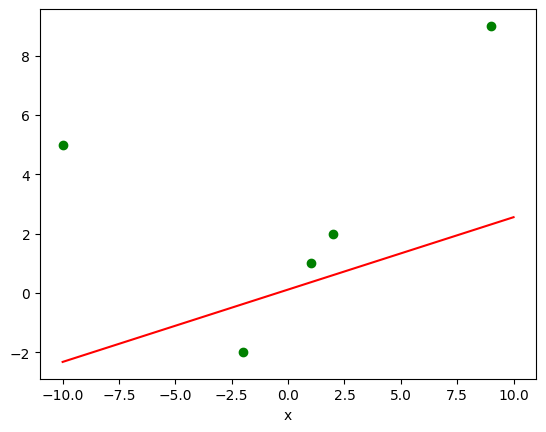

[0.24382477 0.11693402]
103.36800203442907



Methods.Momentum Regularization.L2 LearningRate.Const


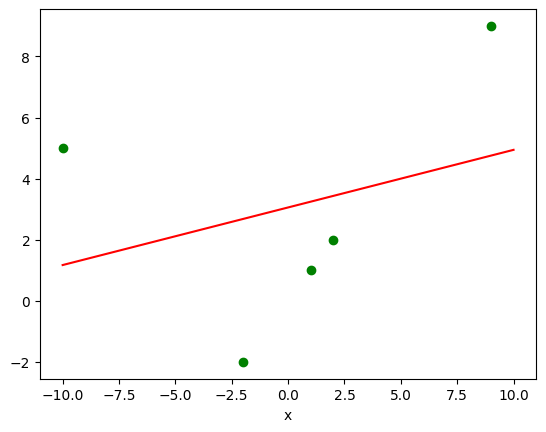

[0.18859172 3.05720647]
62.15582821860298



Methods.Momentum Regularization.L2 LearningRate.Dichotomy


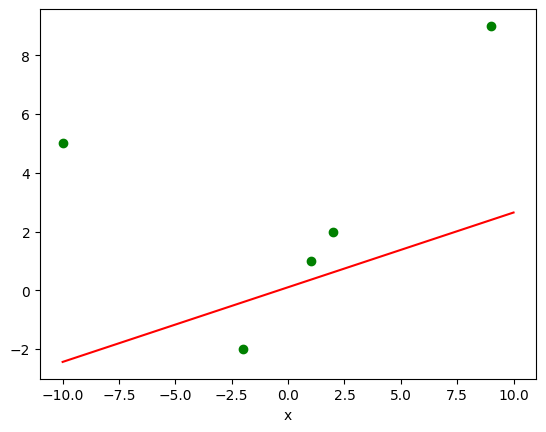

[0.25427886 0.10590014]
103.82552526658259



Methods.Momentum Regularization.Elastic LearningRate.Const


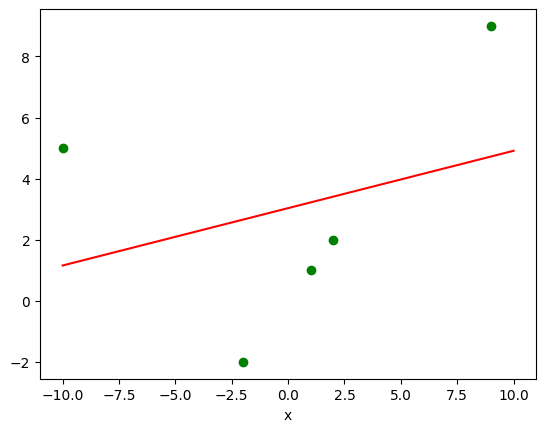

[0.18775465 3.03455221]
62.3067442022085



Methods.Momentum Regularization.Elastic LearningRate.Dichotomy


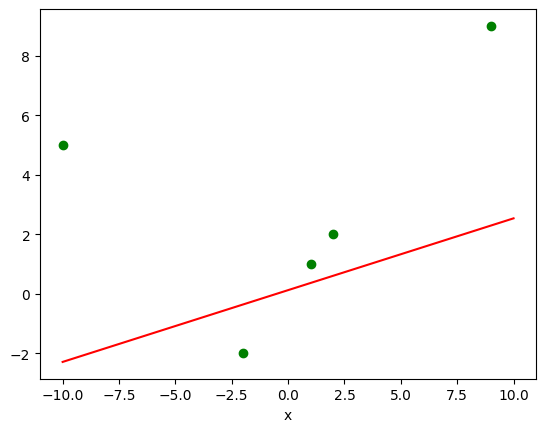

[0.24118455 0.12349651]
103.15080036715965



Methods.AdaGrad Regularization.WithoutRegularization LearningRate.Const


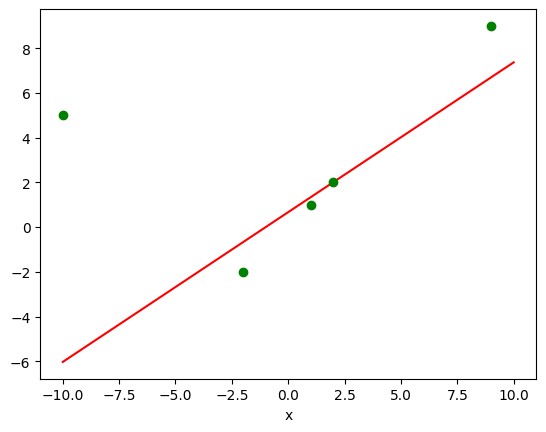

[0.6700228  0.67009049]
128.83737210397575



Methods.AdaGrad Regularization.WithoutRegularization LearningRate.Dichotomy


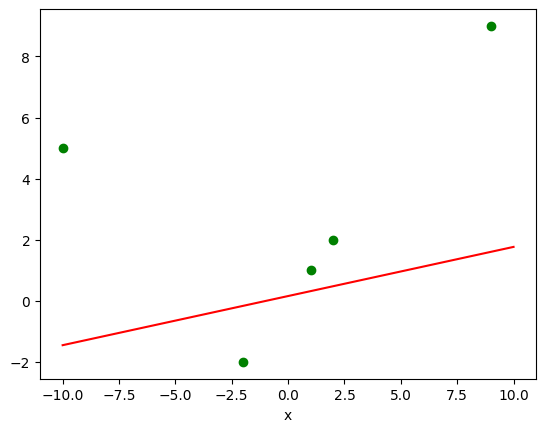

[0.16090079 0.15676737]
102.46671811199005



Methods.AdaGrad Regularization.L1 LearningRate.Const


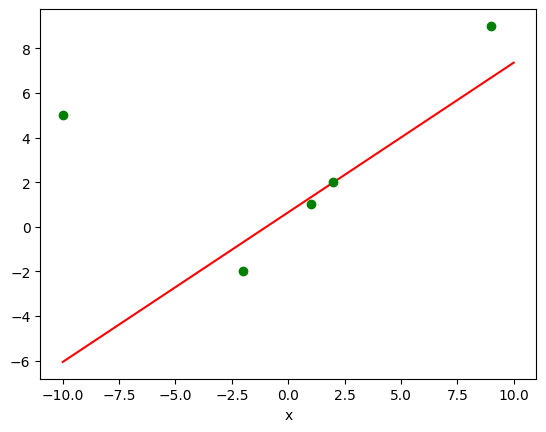

[0.67036775 0.64999483]
129.43387526863287



Methods.AdaGrad Regularization.L1 LearningRate.Dichotomy


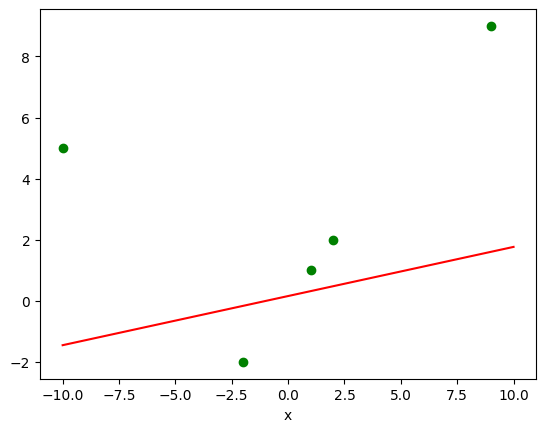

[0.16090079 0.15676737]
102.48260151965243



Methods.AdaGrad Regularization.L2 LearningRate.Const


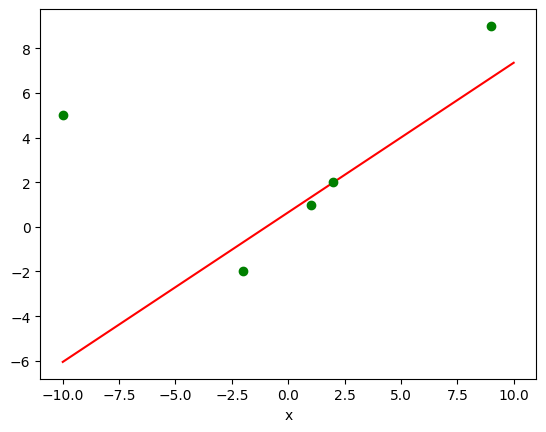

[0.67006217 0.64983374]
129.36182644417931



Methods.AdaGrad Regularization.L2 LearningRate.Dichotomy


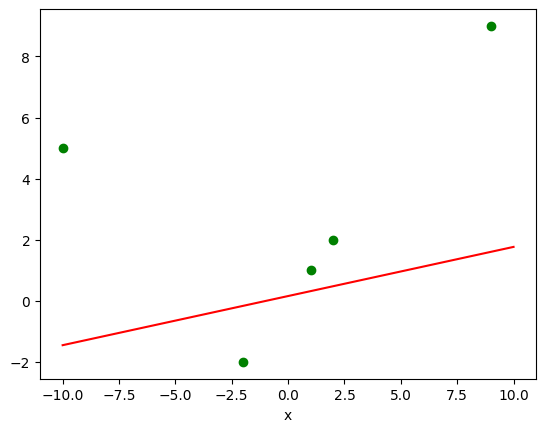

[0.16090079 0.15676737]
102.46924136550861



Methods.AdaGrad Regularization.Elastic LearningRate.Const


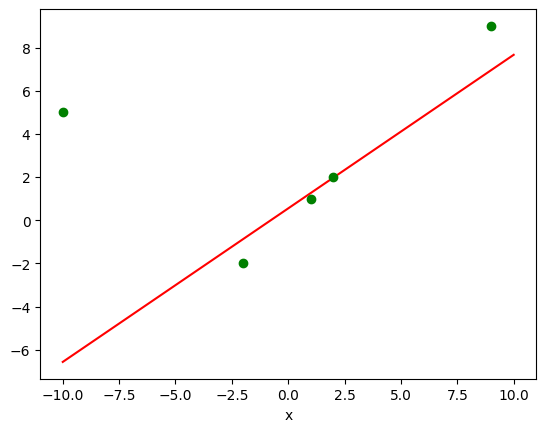

[0.71123629 0.54971752]
139.33680937234354



Methods.AdaGrad Regularization.Elastic LearningRate.Dichotomy


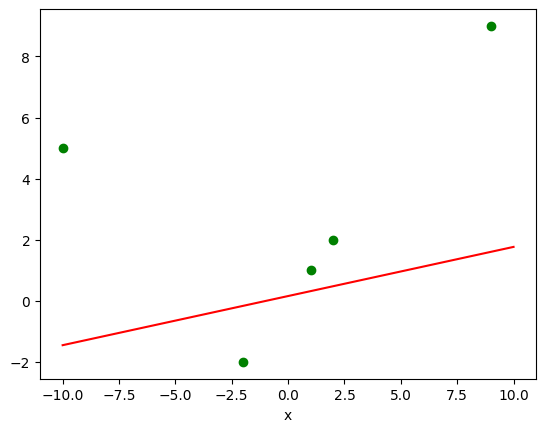

[0.16090079 0.15676737]
102.4851247731711



Methods.RMSprop Regularization.WithoutRegularization LearningRate.Const


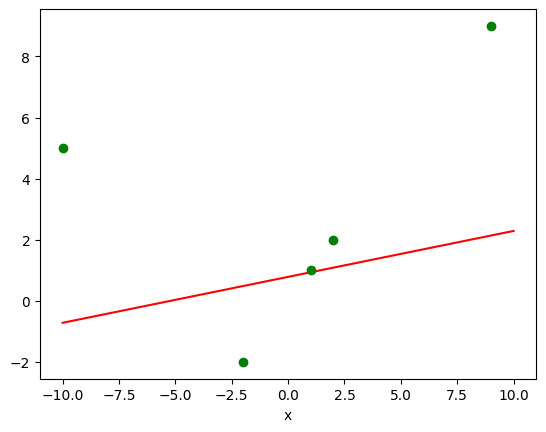

[0.15036546 0.78441985]
86.81059687458041



Methods.RMSprop Regularization.WithoutRegularization LearningRate.Dichotomy


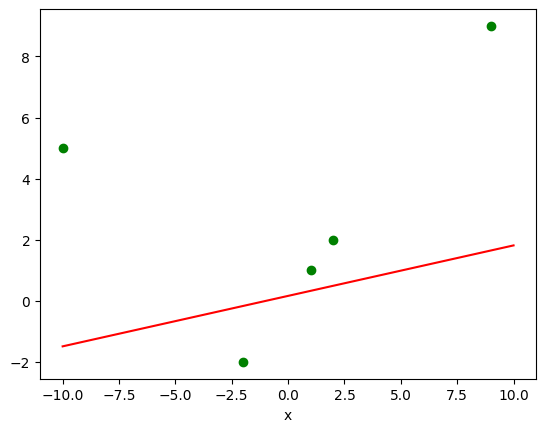

[0.16524125 0.16197502]
102.24051638442702



Methods.RMSprop Regularization.L1 LearningRate.Const


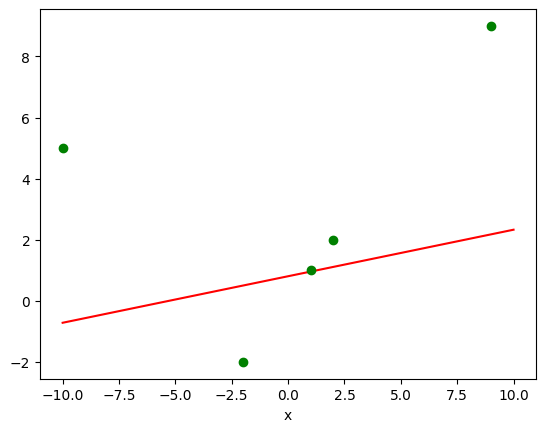

[0.15232921 0.80522937]
86.35542752771926



Methods.RMSprop Regularization.L1 LearningRate.Dichotomy


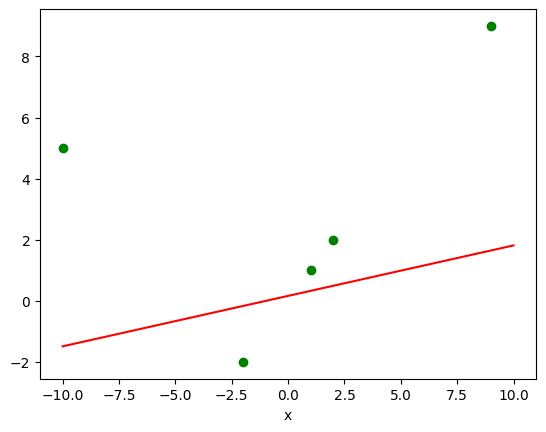

[0.1651973  0.16198748]
102.25727862189584



Methods.RMSprop Regularization.L2 LearningRate.Const


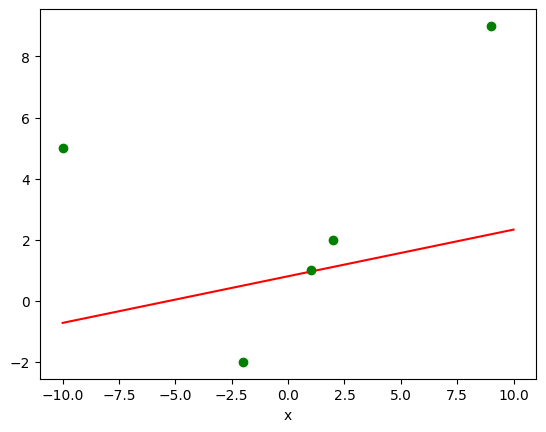

[0.15269036 0.80472069]
86.34429762671226



Methods.RMSprop Regularization.L2 LearningRate.Dichotomy


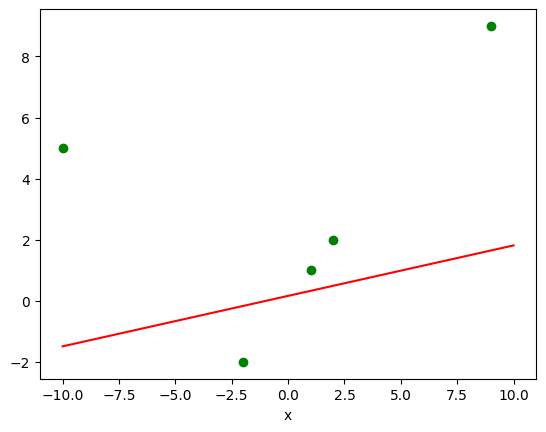

[0.16520981 0.16205951]
102.24133759242854



Methods.RMSprop Regularization.Elastic LearningRate.Const


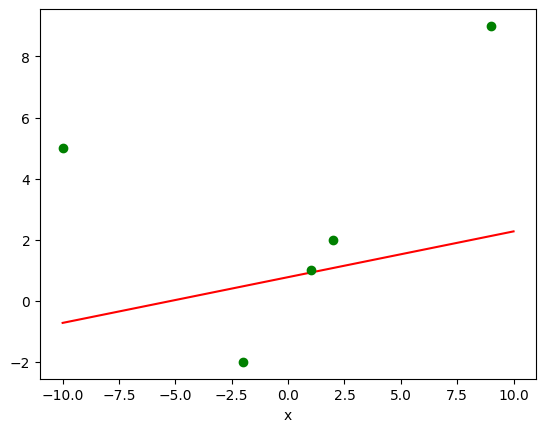

[0.14978953 0.77557096]
87.09773737631413



Methods.RMSprop Regularization.Elastic LearningRate.Dichotomy


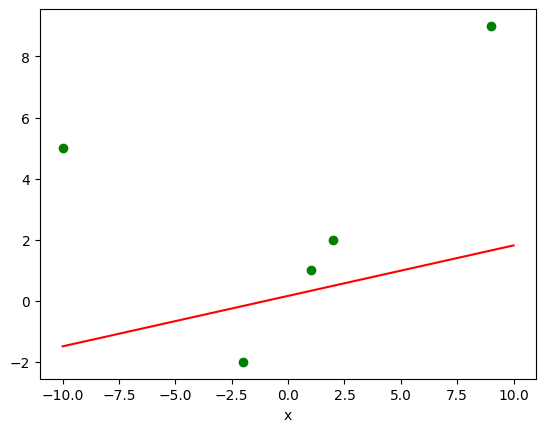

[0.16519228 0.16195828]
102.26086813528326



Methods.Adam Regularization.WithoutRegularization LearningRate.Const


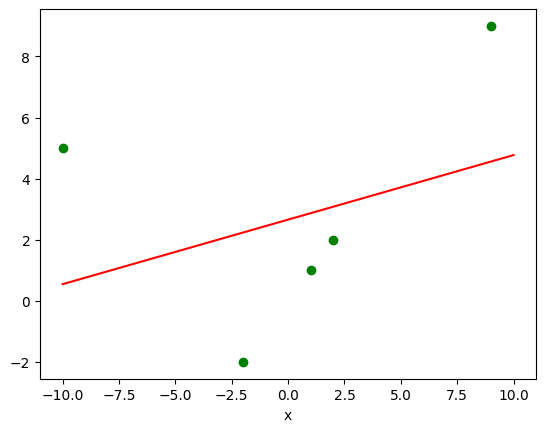

[0.21129314 2.65830794]
62.162826395123446



Methods.Adam Regularization.WithoutRegularization LearningRate.Dichotomy


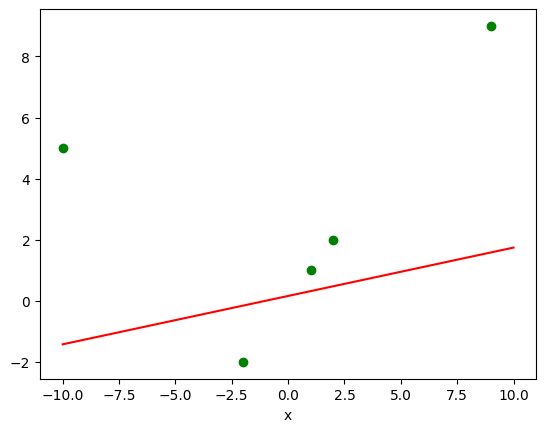

[0.15837396 0.15956666]
102.43603032061725



Methods.Adam Regularization.L1 LearningRate.Const


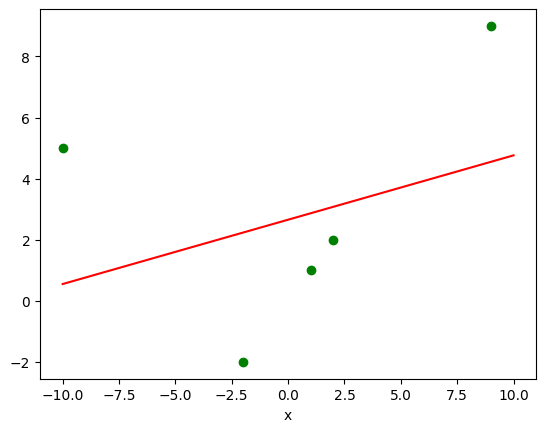

[0.21063898 2.65595865]
62.31410193004662



Methods.Adam Regularization.L1 LearningRate.Dichotomy


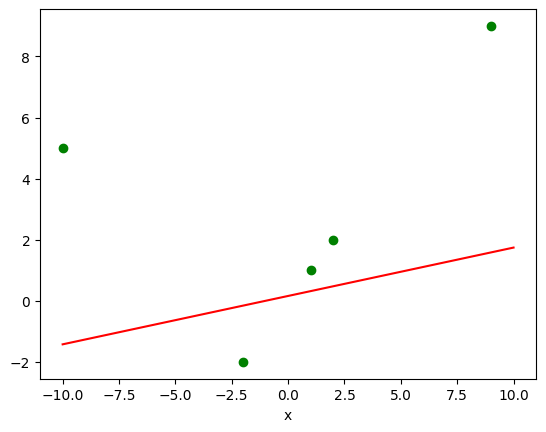

[0.15838936 0.15957916]
102.45126845617307



Methods.Adam Regularization.L2 LearningRate.Const


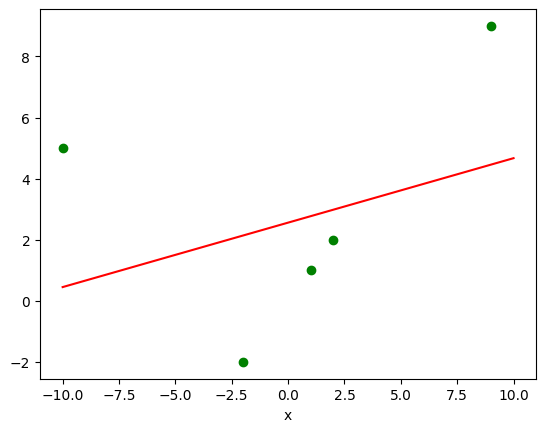

[0.21102526 2.56011788]
62.87641282581741



Methods.Adam Regularization.L2 LearningRate.Dichotomy


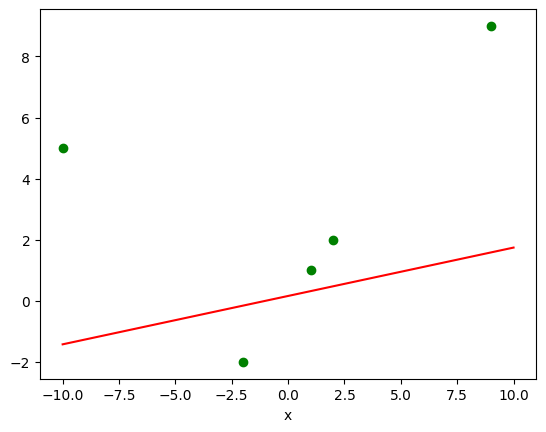

[0.15837828 0.15957008]
102.43837475398719



Methods.Adam Regularization.Elastic LearningRate.Const


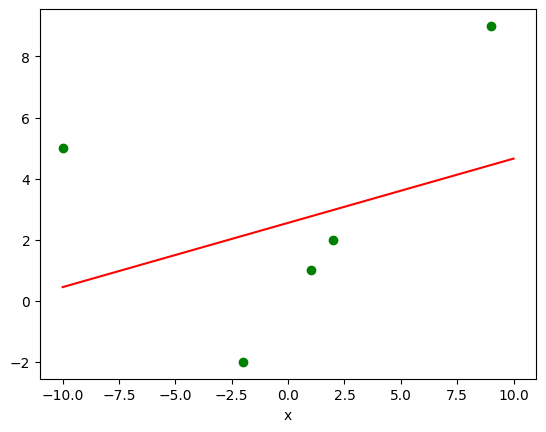

[0.21037168 2.55281209]
63.04505152508457



Methods.Adam Regularization.Elastic LearningRate.Dichotomy


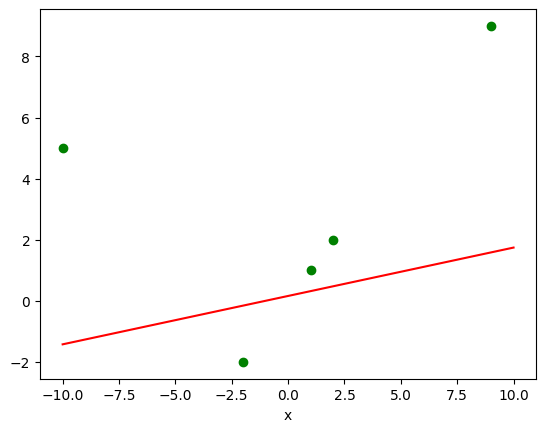

[0.15839372 0.15958244]
102.45361699892028



Methods.Nesterov Regularization.WithoutRegularization LearningRate.Const


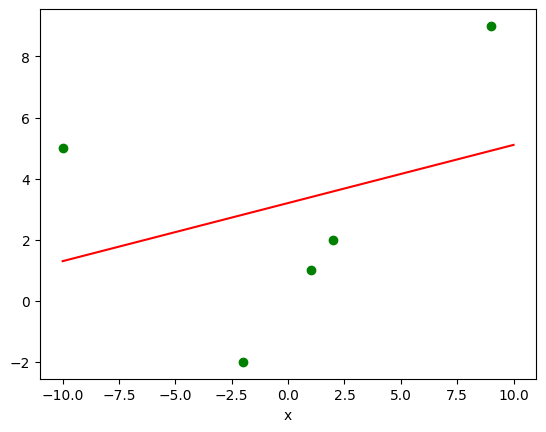

[0.19031467 3.20193538]
61.860453850394336



Methods.Nesterov Regularization.WithoutRegularization LearningRate.Dichotomy


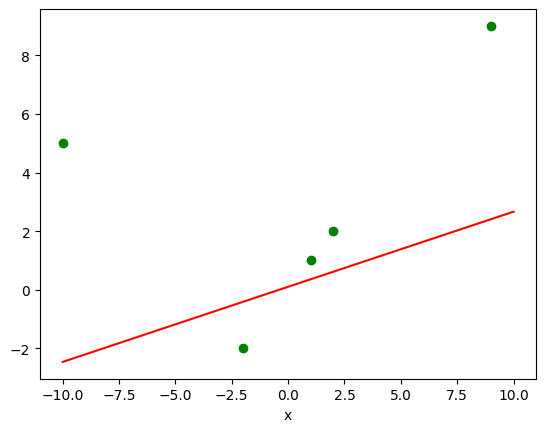

[0.25618592 0.10210597]
103.96400819929238



Methods.Nesterov Regularization.L1 LearningRate.Const


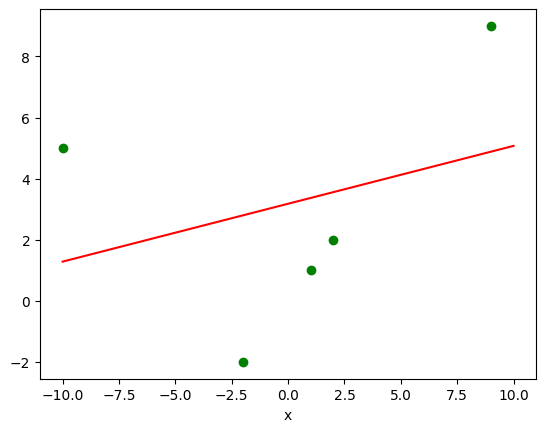

[0.18946588 3.17820835]
61.99039513366119



Methods.Nesterov Regularization.L1 LearningRate.Dichotomy


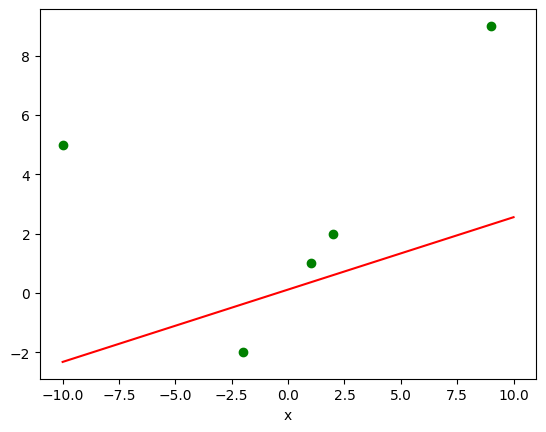

[0.24382477 0.11693402]
103.36800203442907



Methods.Nesterov Regularization.L2 LearningRate.Const


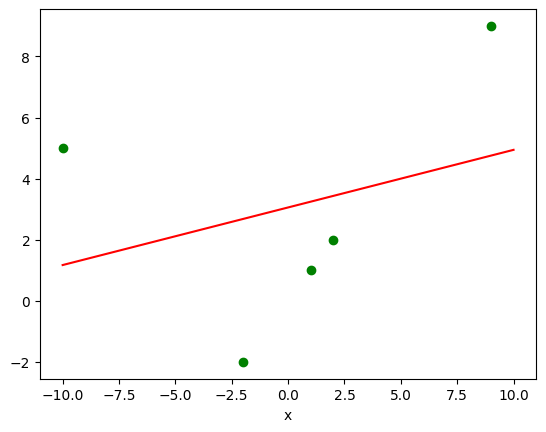

[0.18859172 3.05720647]
62.15582821860298



Methods.Nesterov Regularization.L2 LearningRate.Dichotomy


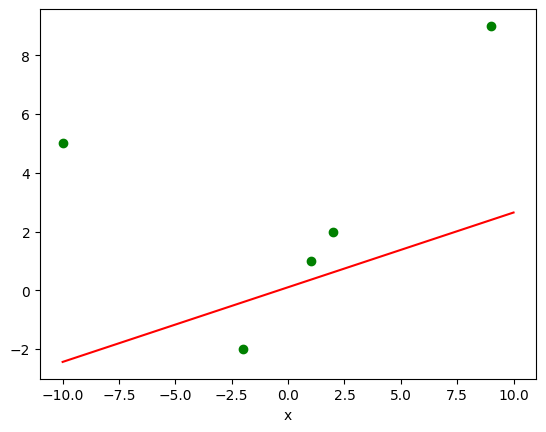

[0.25427886 0.10590014]
103.82552526658259



Methods.Nesterov Regularization.Elastic LearningRate.Const


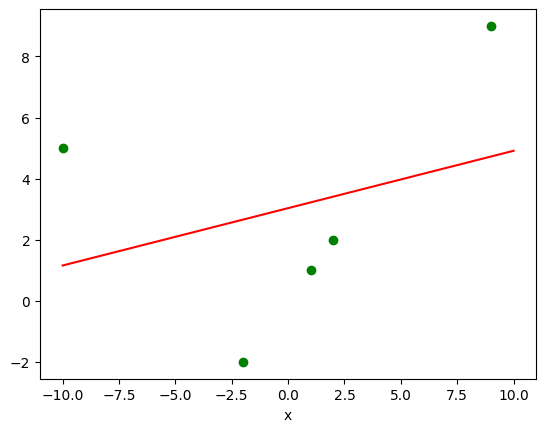

[0.18775465 3.03455221]
62.3067442022085



Methods.Nesterov Regularization.Elastic LearningRate.Dichotomy


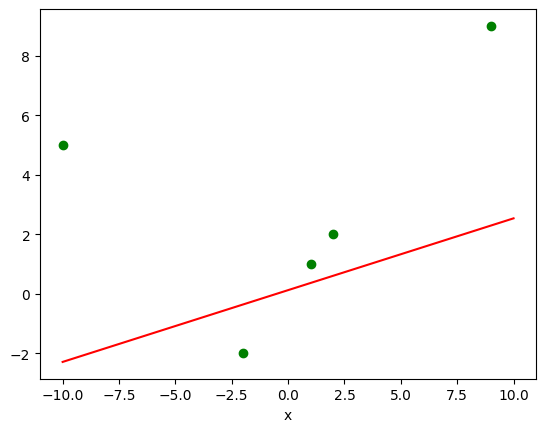

[0.24118455 0.12349651]
103.15080036715965





In [24]:
current_t = np.array([lambda x: x, lambda x: 1.])
current_w = np.array([0., 0.])
current_x = np.array([1., 2., 9., -2., -10.])
current_y = np.array([1., 2., 9., -2., 5])

for method in Methods:
    for regularization in Regularization:
        for lr in LearningRate:
            linear_reg_const = LinearRegression(
                current_t, current_w, current_x, current_y, regularization
            )
            print(str(method) + " " + str(regularization) + " " + str(lr))
            if lr == LearningRate.Const:
                sgd_handler(linear_reg_const, lambda x: 0.01, method)
            elif lr == LearningRate.Dichotomy:
                sgd_handler(linear_reg_const, lr_dichotomy(0.001, 0.0001), method)
            visualise_points(linear_reg_const)
            current_w = np.array([0., 0.])
            print("\n\n")